In [ ]:
from transformers import BertTokenizer, BertModel
import os
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from transformers import get_linear_schedule_with_warmup
import gc
import numpy as np
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt



/home/vasilis/anaconda3/envs/tfgpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

data_path = './data/VulnExtractData/ffmpeg_test'
train_path = data_path + '/Train'
test_path = data_path + '/Test'
train_path,test_path


('./data/VulnExtractData/ffmpeg_test/Train',
 './data/VulnExtractData/ffmpeg_test/Test')

In [ ]:
task_list = ['AF','BF','CL']

In [ ]:



def train_model_svm(X_train,Y_train,X_test,Y_test):
    param_grid = {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['linear', 'rbf', 'poly'],
        'svc__degree': [2, 3, 4],
        'svc__gamma': ['scale', 'auto']
    }
    

    pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1,1)), SVC(probability=True))
    grid_search = GridSearchCV(pipeline,param_grid,verbose = 0,n_jobs = -1)

    grid_search.fit(X_train,Y_train)

    print(f"Best parameters: {grid_search.best_params_}")

    Y_pred = grid_search.best_estimator_.predict(X_test)

    print(classification_report(Y_test, Y_pred, digits=4))

def train_model_svm_with_features(X_train,Y_train,X_test,Y_test):
    param_grid = {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['linear', 'rbf', 'poly'],
        'svc__degree': [2, 3, 4],
        'svc__gamma': ['scale', 'auto']
    }

    preprocessor = ColumnTransformer([
        ('tfidf', TfidfVectorizer(), 'Description'),  # only your text column name here
        ('scaler', StandardScaler(), X_train.columns[1:])
    ], remainder='drop')

    pipeline = make_pipeline(preprocessor, SVC(probability=True))

    grid_search = GridSearchCV(pipeline,param_grid,verbose = 0,n_jobs = -1)

    grid_search.fit(X_train,Y_train)

    print(f"Best parameters: {grid_search.best_params_}")

    Y_pred = grid_search.best_estimator_.predict(X_test)

    print(classification_report(Y_test, Y_pred, digits=4))

 

In [ ]:


def prepare_data(task_id,with_features = False):    
    folder_train_path = train_path + '/' + task_id

    all_train_files = []
    for root, dirs, files in os.walk(folder_train_path):
        for file in files:
            full_path = os.path.join(root, file)
            all_train_files.append(full_path)

    dfs = [pd.read_csv(file) for file in all_train_files]

    folder_test_path = test_path + '/' + task_id

    all_test_files = []
    for root, dirs, files in os.walk(folder_test_path):
        for file in files:
            full_path = os.path.join(root, file)
            all_test_files.append(full_path)

    dfs_train = [pd.read_csv(file) for file in all_train_files]

    dfs_test = [pd.read_csv(file) for file in all_test_files]

    df_train = pd.concat(dfs_train, ignore_index=True)

    df_test  = pd.concat(dfs_test, ignore_index=True)

    #use only Description for training
    X_train_descriptions = df_train['Description']
    X_test_descriptions = df_test['Description']

    if with_features == True:
        X_train_features = df_train.drop(columns=['Description', 'label', 'CVE_ID'])
        X_test_features = df_test.drop(columns=['Description', 'label', 'CVE_ID'])

        X_train = pd.concat([X_train_descriptions,X_train_features],axis=1)
        X_test = pd.concat([X_test_descriptions,X_test_features],axis=1)
    else:
        X_train = X_train_descriptions
        X_test = X_test_descriptions

    Y_train = df_train['label'].apply(lambda x:0 if x==4 else 1).values
    Y_test = df_test['label'].apply(lambda x:0 if x==4 else 1).values
   
    return X_train,Y_train,X_test,Y_test



for task_id in task_list:
    print(f"Training task {task_id} without features")
    X_train,Y_train,X_test,Y_test = prepare_data(task_id, with_features=False)
    train_model_svm(X_train,Y_train,X_test,Y_test)
    print(f"Training task {task_id} with features")
    X_train,Y_train,X_test,Y_test = prepare_data(task_id, with_features=True)
    train_model_svm_with_features(X_train,Y_train,X_test,Y_test)



Training task AF without features
Best parameters: {'svc__C': 1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

           0     0.8923    0.8215    0.8555       353
           1     0.6881    0.7989    0.7394       174

    accuracy                         0.8140       527
   macro avg     0.7902    0.8102    0.7974       527
weighted avg     0.8249    0.8140    0.8171       527

Training task AF with features
Best parameters: {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

           0     0.9590    0.9943    0.9764       353
           1     0.9876    0.9138    0.9493       174

    accuracy                         0.9677       527
   macro avg     0.9733    0.9541    0.9628       527
weighted avg     0.9684    0.9677    0.9674       527

Training task BF without features
Best parameters: {'svc__C': 10, 'svc__degree': 2, 'svc

/home/vasilis/anaconda3/envs/tfgpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vasilis/anaconda3/envs/tfgpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vasilis/anaconda3/envs/tfgpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Best parameters: {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961       512
           1     1.0000    0.7333    0.8462        15

    accuracy                         0.9924       527
   macro avg     0.9961    0.8667    0.9211       527
weighted avg     0.9925    0.9924    0.9918       527

Training task CL without features
Best parameters: {'svc__C': 1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

           0     0.9383    0.9444    0.9414       306
           1     0.9224    0.9140    0.9182       221

    accuracy                         0.9317       527
   macro avg     0.9303    0.9292    0.9298       527
weighted avg     0.9316    0.9317    0.9316       527

Training task CL with features
Best parameters: {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kerne

In [ ]:
def plot_loss_curves(train_accuracies,train_losses,val_accuracies,val_losses,task_id,with_features=False):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = train_losses
  val_loss = val_losses

  accuracy = train_accuracies
  val_accuracy = val_accuracies

  epochs = range(1, len(train_accuracies) + 1)

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title(f'{task_id}_Loss_{"with_features" if with_features else "without_features"}')
  plt.xlabel('Epochs')
  plt.xticks(epochs)   
  plt.legend()

  display(plt.gcf())
  plt.close()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title(f'{task_id}_Accuracy_{"with_features" if with_features else "without_features"}')
  plt.xlabel('Epochs')
  plt.legend()
  plt.xticks(epochs)   
  display(plt.gcf())
  plt.close()

In [ ]:
class TextDataset(Dataset):
    def __init__(self,df,tokenizer,max_len = 512):
        self.tokenizer = tokenizer
        self.df = df
        self.max_len = max_len
        self.texts = df['Description']
        self.labels =  df['label'].apply(lambda x:0 if x==4 else 1).values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,index):
        text = self.texts[index]
        labels = self.labels[index]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            padding=False 
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove the batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(labels, dtype=torch.long)
        }
    

class TextFeatureDataset(Dataset):
    def __init__(self,df,tokenizer,max_len = 512):
        
        self.tokenizer = tokenizer
        self.df = df
        feature_cols = [col for col in df.columns if col not in ['Description', 'CVE_ID', 'label']]
        self.max_len = max_len
        self.features = df[feature_cols].astype(float)
        self.texts = df['Description']
        self.labels =  df['label'].apply(lambda x:0 if x==4 else 1).values

            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        text = self.texts[index]
        labels = self.labels[index]
        features = self.features.iloc[index].to_numpy(dtype=np.float32, copy=True)
        features = torch.from_numpy(features).contiguous() 
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            padding=False 
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove the batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'features': features,
            'labels': torch.tensor(labels, dtype=torch.long)
        }    

class BertClassifierWithFeatures(nn.Module):
    def __init__(self,bert_model_name='bert-base-uncased',num_additional_features=16, num_classes=2):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name,num_labels=num_classes)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_additional_features, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self,input_ids,attention_mask,features):
        outputs = self.bert(input_ids,attention_mask = attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        combined = torch.cat((cls_embedding, features), dim=1)
        combined = self.dropout(combined)
        outputs = self.classifier(combined)
        return outputs

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    features = [item['features'] for item in batch]
    
  
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    features = torch.stack(features)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'features': features,
        'labels': labels
    }

def train_model(model,model_class ,df_train,df_val, device, optimizer,tokenizer,epochs=3):
    model.to(device)
    train_losses=[]
    train_accuracies= []
    val_losses = []
    val_accuracies = []
    train_dataset = TextFeatureDataset(df_train,tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn,num_workers=0)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        model.train()
        n_correct = 0
        n_samples = 0
        total_loss = 0

        for i,batch in enumerate(train_loader):
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            features = batch['features'].to(device)
        
            model.zero_grad()
            outputs,loss,preds = None,None,None
            if model_class  ==  BertClassifierWithFeatures:
                outputs = model(input_ids = input_ids,attention_mask = attention_mask,features=features)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                logits = torch.softmax(outputs,dim=1)
                preds = torch.argmax(logits, dim=1)
            else:
                outputs = model(input_ids,attention_mask = attention_mask,labels=labels)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits,dim =1 )

            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

            n_samples += labels.shape[0]
            n_correct += (preds == labels).sum().item()

            if i % 100 == 0 :
                print(f'Epoch:{epoch+1} Step:{i+1}/{len(train_loader)} Loss:{loss.item()}')
            
            if i % 80 == 0 :
                time.sleep(5)

        results = evaluate_model(model=model,model_class=model_class,df_test=df_val,tokenizer=tokenizer)

        avg_loss = total_loss/len(train_loader)
        accuracy = n_correct/n_samples
        
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        val_accuracies.append(results['accuracy'])
        val_losses.append(results['loss'])

    return train_losses,train_accuracies,val_losses,val_accuracies


        
def run_training(model_name,model_class,tokenizer,df_train,df_val,epochs = 2,learning_rate = 5e-5,task_id=None,with_features=False):
    gc.collect() 
    torch.cuda.empty_cache()      # releases cached GPU memory back to the driver

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_class == BertClassifierWithFeatures:
        feature_cols = [col for col in df_train.columns if col not in ['Description', 'CVE_ID', 'label']]
        num_features = len(feature_cols)
    #   print(num_features)
        model = model_class(model_name,num_additional_features = num_features, num_classes=2)
        
    else: 
        model = model_class.from_pretrained(model_name, num_labels=2)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    train_losses,train_accuracies,val_losses,val_accuracies= train_model(model,
                                          model_class=model_class,
                                          df_train=df_train,
                                          df_val = df_val, 
                                          device=device,
                                          optimizer=optimizer, 
                                          tokenizer=tokenizer, 
                                          epochs=epochs
                                        )
    
    plot_loss_curves(train_accuracies,train_losses,val_accuracies,val_losses,task_id=task_id,with_features=with_features)
    print("\n===== Training Summary =====")
    for epoch in range(len(train_losses)):
        print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_losses[epoch]:.4f} | "
        f"Train Acc: {train_accuracies[epoch]*100:.2f}% | "
        f"Val Loss: {val_losses[epoch]:.4f} | "
        f"Val Acc: {val_accuracies[epoch]*100:.2f}%"
        )
    print("============================\n")
    torch.cuda.synchronize()
    gc.collect()
    torch.cuda.empty_cache()
    print("Training finished.")
    print("============================\n")
    return model
    

def evaluate_model(model,model_class,df_test,tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_dataset = TextFeatureDataset(df_test,tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn,num_workers=0)

    n_correct = 0
    n_samples = 0
    total_loss = 0
    predictions =  []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            features = batch['features'].to(device)

            outputs,loss,preds = None,None,None

            if model_class  ==  BertClassifierWithFeatures:
                outputs = model(input_ids = input_ids,attention_mask = attention_mask,features=features)
                logits = torch.softmax(outputs,dim=1)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                preds = torch.argmax(logits,dim = 1)
                
            else:
                outputs = model(input_ids,attention_mask = attention_mask)
                preds = torch.argmax(outputs.logits,dim = 1)
                loss = nn.CrossEntropyLoss()(outputs.logits, labels)

            total_loss += loss.item()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
           
            n_samples += labels.shape[0]
            n_correct += (preds == labels).sum().item()
    avg_loss = total_loss/len(test_loader) 
    acc = n_correct/ n_samples

    return {'accuracy':acc,"loss":avg_loss}
    

    


Training task AF without features


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:1 Step:1/238 Loss:0.6378406286239624
Epoch:1 Step:101/238 Loss:0.09071925282478333
Epoch:1 Step:201/238 Loss:0.07826411724090576
Epoch:2 Step:1/238 Loss:0.1859695315361023
Epoch:2 Step:101/238 Loss:0.06494112312793732
Epoch:2 Step:201/238 Loss:0.02655588649213314


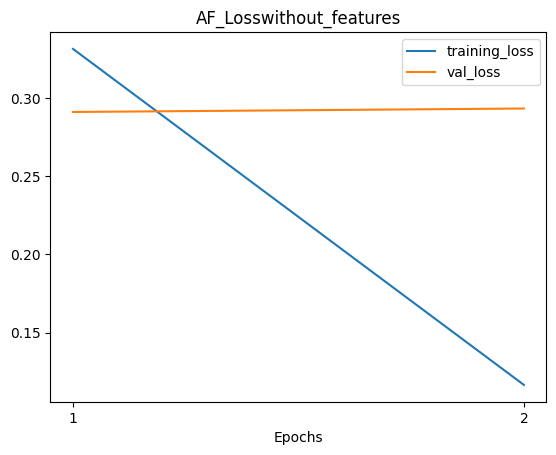

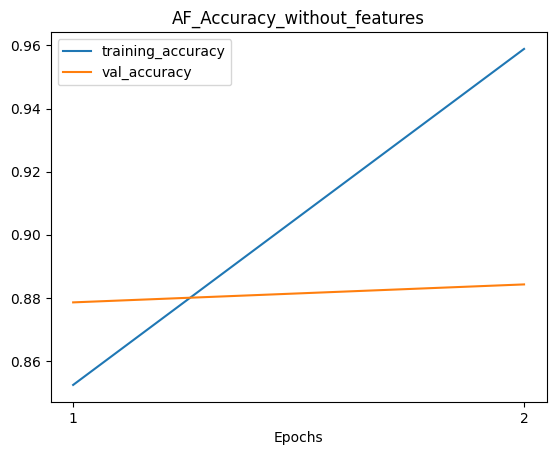


===== Training Summary =====
Epoch 01 | Train Loss: 0.3314 | Train Acc: 85.24% | Val Loss: 0.2910 | Val Acc: 87.86%
Epoch 02 | Train Loss: 0.1165 | Train Acc: 95.89% | Val Loss: 0.2933 | Val Acc: 88.43%

Training finished.

Training task AF with features
Epoch:1 Step:1/238 Loss:0.7408244609832764
Epoch:1 Step:101/238 Loss:0.10169203579425812
Epoch:1 Step:201/238 Loss:0.13922005891799927
Epoch:2 Step:1/238 Loss:0.36061251163482666
Epoch:2 Step:101/238 Loss:0.0469086728990078
Epoch:2 Step:201/238 Loss:0.021725287660956383


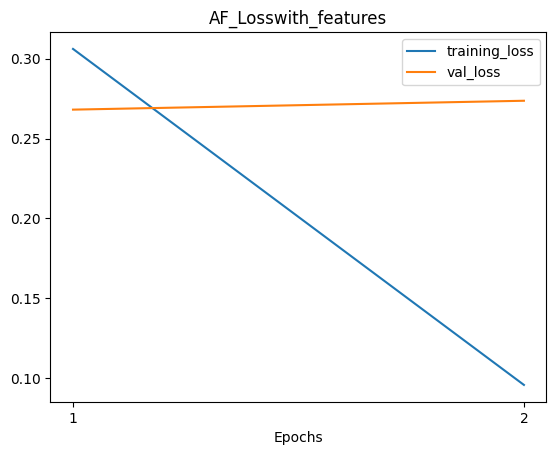

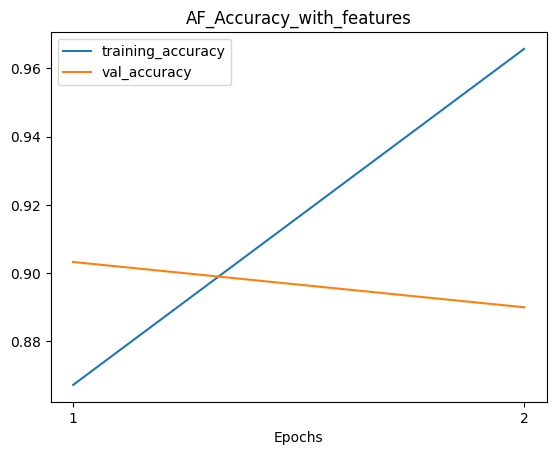


===== Training Summary =====
Epoch 01 | Train Loss: 0.3062 | Train Acc: 86.72% | Val Loss: 0.2681 | Val Acc: 90.32%
Epoch 02 | Train Loss: 0.0956 | Train Acc: 96.57% | Val Loss: 0.2737 | Val Acc: 88.99%

Training finished.

Training task BF without features


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:1 Step:1/238 Loss:0.9488227367401123
Epoch:1 Step:101/238 Loss:0.030014371499419212
Epoch:1 Step:201/238 Loss:0.03707387298345566
Epoch:2 Step:1/238 Loss:0.011910932138562202
Epoch:2 Step:101/238 Loss:0.3951352536678314
Epoch:2 Step:201/238 Loss:0.012371057644486427


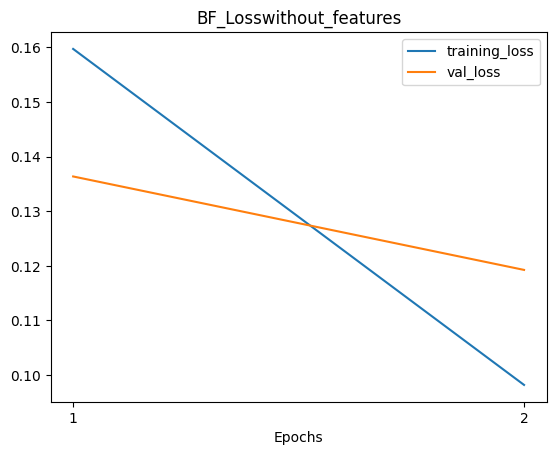

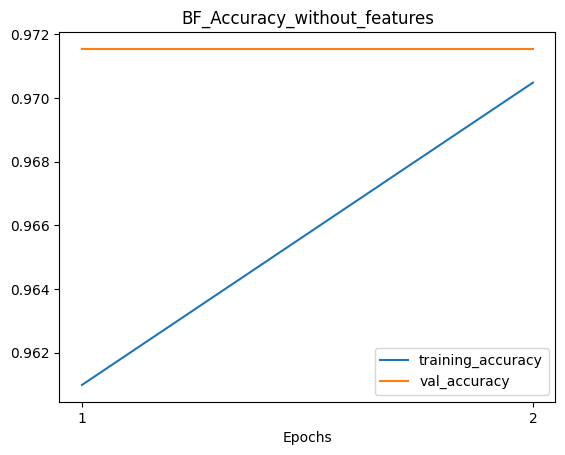


===== Training Summary =====
Epoch 01 | Train Loss: 0.1597 | Train Acc: 96.10% | Val Loss: 0.1364 | Val Acc: 97.15%
Epoch 02 | Train Loss: 0.0982 | Train Acc: 97.05% | Val Loss: 0.1193 | Val Acc: 97.15%

Training finished.

Training task BF with features
Epoch:1 Step:1/238 Loss:0.5296823978424072
Epoch:1 Step:101/238 Loss:0.434688001871109
Epoch:1 Step:201/238 Loss:0.3883717954158783
Epoch:2 Step:1/238 Loss:0.016109827905893326
Epoch:2 Step:101/238 Loss:0.00496935099363327
Epoch:2 Step:201/238 Loss:0.12331260740756989


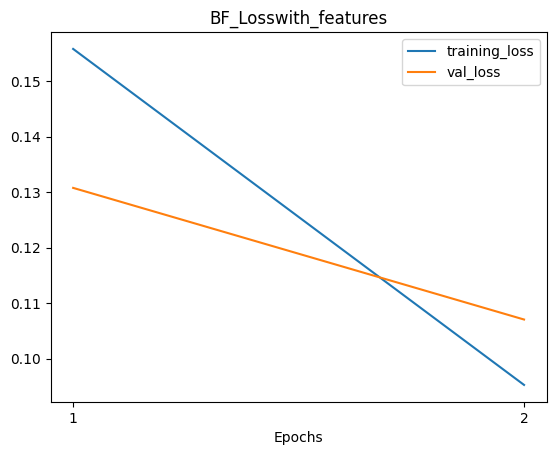

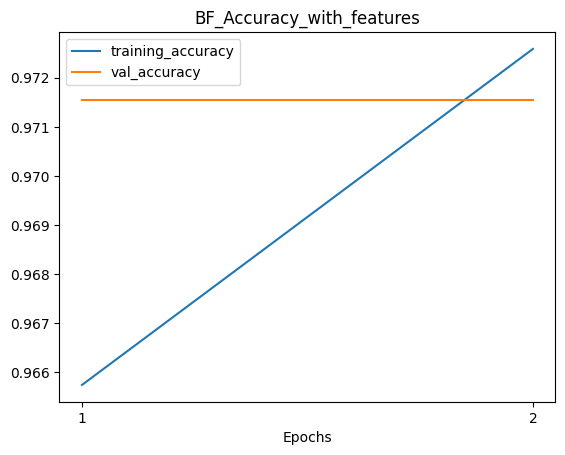


===== Training Summary =====
Epoch 01 | Train Loss: 0.1558 | Train Acc: 96.57% | Val Loss: 0.1308 | Val Acc: 97.15%
Epoch 02 | Train Loss: 0.0953 | Train Acc: 97.26% | Val Loss: 0.1071 | Val Acc: 97.15%

Training finished.

Training task CL without features


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:1 Step:1/238 Loss:0.9618585109710693
Epoch:1 Step:101/238 Loss:0.1726573258638382
Epoch:1 Step:201/238 Loss:1.0026273727416992
Epoch:2 Step:1/238 Loss:0.03487834334373474
Epoch:2 Step:101/238 Loss:0.05824758857488632
Epoch:2 Step:201/238 Loss:0.015089072287082672


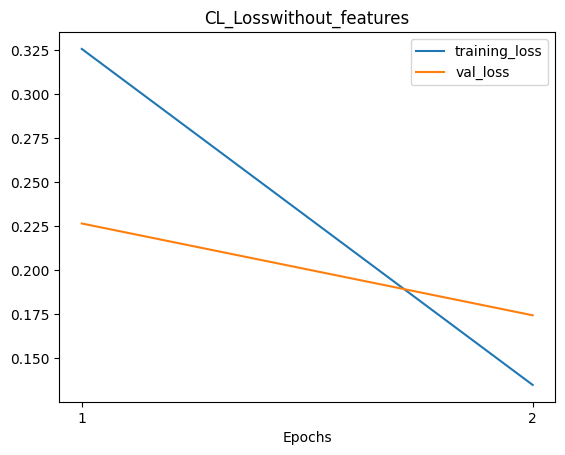

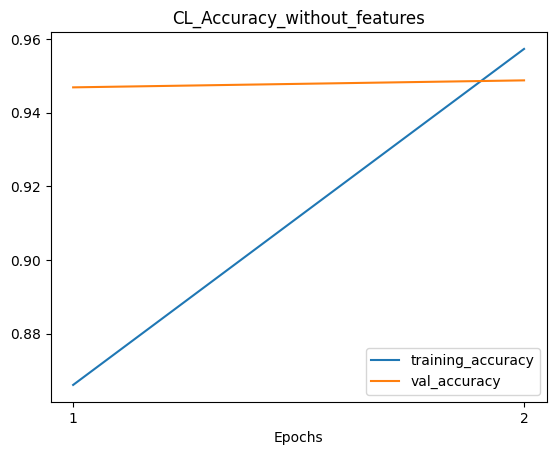


===== Training Summary =====
Epoch 01 | Train Loss: 0.3257 | Train Acc: 86.61% | Val Loss: 0.2266 | Val Acc: 94.69%
Epoch 02 | Train Loss: 0.1350 | Train Acc: 95.73% | Val Loss: 0.1745 | Val Acc: 94.88%

Training finished.

Training task CL with features
Epoch:1 Step:1/238 Loss:0.739395797252655


In [ ]:

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)


def prepare_data(task_id):    
    folder_train_path = train_path + '/' + task_id

    all_train_files = []
    for root, dirs, files in os.walk(folder_train_path):
        for file in files:
            full_path = os.path.join(root, file)
            all_train_files.append(full_path)

    dfs = [pd.read_csv(file) for file in all_train_files]

    folder_test_path = test_path + '/' + task_id

    all_test_files = []
    for root, dirs, files in os.walk(folder_test_path):
        for file in files:
            full_path = os.path.join(root, file)
            all_test_files.append(full_path)

    dfs_train = [pd.read_csv(file) for file in all_train_files]

    dfs_test = [pd.read_csv(file) for file in all_test_files]

    df_train = pd.concat(dfs_train, ignore_index=True)

    df_test  = pd.concat(dfs_test, ignore_index=True)

    return df_train,df_test


models = {}

for task_id in task_list:
    print(f"Training task {task_id} without features")
    df_train ,df_test = prepare_data(task_id)

    model_class = AutoModelForSequenceClassification
    model = run_training(model_name,model_class,tokenizer,df_train,df_test,task_id=task_id,with_features=False)
    key = f'text_only_{task_id}'
    models[key] = model
    time.sleep(5)


    print(f"Training task {task_id} with features")
    model_class = BertClassifierWithFeatures    
   
    model = run_training(model_name,model_class,tokenizer,df_train,df_test,task_id=task_id,with_features=True)
    key = f'text_and_features_{task_id}'
    models[key] = model
    time.sleep(5)



    

In [ ]:
for name,model in models.items():
    path = f"./saved_models/{name}"
    os.makedirs(path, exist_ok=True)

    if hasattr(model, "save_pretrained"):  # Hugging Face model
        model.save_pretrained(path)
    else:  # Custom torch.nn model
        torch.save(model.state_dict(), os.path.join(path, "model.pt"))